# Prepare Data

In [2]:
import tensorflow as tf
import cv2
import shutil

from numba import cuda 

from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Input, Softmax, Conv1D, MaxPooling1D, Activation
from keras.engine.saving import model_from_json
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils.vis_utils import plot_model
from keras.layers.normalization import BatchNormalization
from keras_preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

from skimage.restoration import denoise_wavelet

from pathlib import Path

from google.colab import files
from google.colab import drive

import os
import sys

import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt

import librosa
import librosa.display

In [3]:
drive.mount('/content/gdrive', force_remount=True)

print("GPU Name: ", tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Mounted at /content/gdrive
GPU Name:  /device:GPU:0
Num GPUs Available:  1


In [4]:
ravdess = "gdrive/My Drive/Public/RAVDESS Audio.zip"
new_file = shutil.copy(ravdess, 'ravdess.zip')

!unzip ravdess.zip

Archive:  ravdess.zip
replace Actor_01/03-01-01-01-01-01-01.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Actor_01/03-01-01-01-01-01-01.wav  
  inflating: Actor_01/03-01-01-01-01-02-01.wav  
  inflating: Actor_01/03-01-01-01-02-01-01.wav  
  inflating: Actor_01/03-01-01-01-02-02-01.wav  
  inflating: Actor_01/03-01-02-01-01-01-01.wav  
  inflating: Actor_01/03-01-02-01-01-02-01.wav  
  inflating: Actor_01/03-01-02-01-02-01-01.wav  
  inflating: Actor_01/03-01-02-01-02-02-01.wav  
  inflating: Actor_01/03-01-02-02-01-01-01.wav  
  inflating: Actor_01/03-01-02-02-01-02-01.wav  
  inflating: Actor_01/03-01-02-02-02-01-01.wav  
  inflating: Actor_01/03-01-02-02-02-02-01.wav  
  inflating: Actor_01/03-01-03-01-01-01-01.wav  
  inflating: Actor_01/03-01-03-01-01-02-01.wav  
  inflating: Actor_01/03-01-03-01-02-01-01.wav  
  inflating: Actor_01/03-01-03-01-02-02-01.wav  
  inflating: Actor_01/03-01-03-02-01-01-01.wav  
  inflating: Actor_01/03-01-03-02-01-02-01.wav  
  inflating: 

In [5]:
actors = [
  "Actor_01", "Actor_02", "Actor_03", "Actor_04", "Actor_05", 
  "Actor_06", "Actor_07", "Actor_08", "Actor_09", "Actor_10",
  "Actor_11", "Actor_12", "Actor_13", "Actor_14", "Actor_15",
  "Actor_16", "Actor_17", "Actor_18", "Actor_19", "Actor_20",
  "Actor_21", "Actor_22", "Actor_23", "Actor_24"
]

result = pd.DataFrame()
result["Actor"] = None
result["Recording"] = None
result["Emotion"] = None
result["Intensity"] = None

def convertLabelToEmotion(label):
  if label == '01': return 'neutral'
  elif label == '02': return 'calm'
  elif label == '03': return 'happy'
  elif label == '04': return 'sad'
  elif label == '05': return 'angry'
  elif label == '06': return 'fearful'
  elif label == '07': return 'disgust'
  elif label == '08': return 'surprised'
  else: return None

for actor in actors:
  recordings = [file.name for file in os.scandir(actor)]
  
  for recording in recordings:
    labels = recording.split('-')
    result = result.append({'Actor': actor, 'Recording': recording, 'Emotion': convertLabelToEmotion(labels[2]), 'Intensity': labels[3]}, ignore_index=True)

result

,Actor,Recording,Emotion,Intensity
0,Actor_01,03-01-08-01-02-01-01.wav,surprised,01
1,Actor_01,03-01-04-02-02-02-01.wav,sad,02
2,Actor_01,03-01-03-02-02-02-01.wav,happy,02
3,Actor_01,03-01-07-02-01-02-01.wav,disgust,02
4,Actor_01,03-01-08-02-02-01-01.wav,surprised,02
...,...,...,...,...
1435,Actor_24,03-01-04-01-02-01-24.wav,sad,01
1436,Actor_24,03-01-06-01-02-02-24.wav,fearful,01
1437,Actor_24,03-01-03-02-01-01-24.wav,happy,02
1438,Actor_24,03-01-05-01-02-02-24.wav,angry,01


# Plot

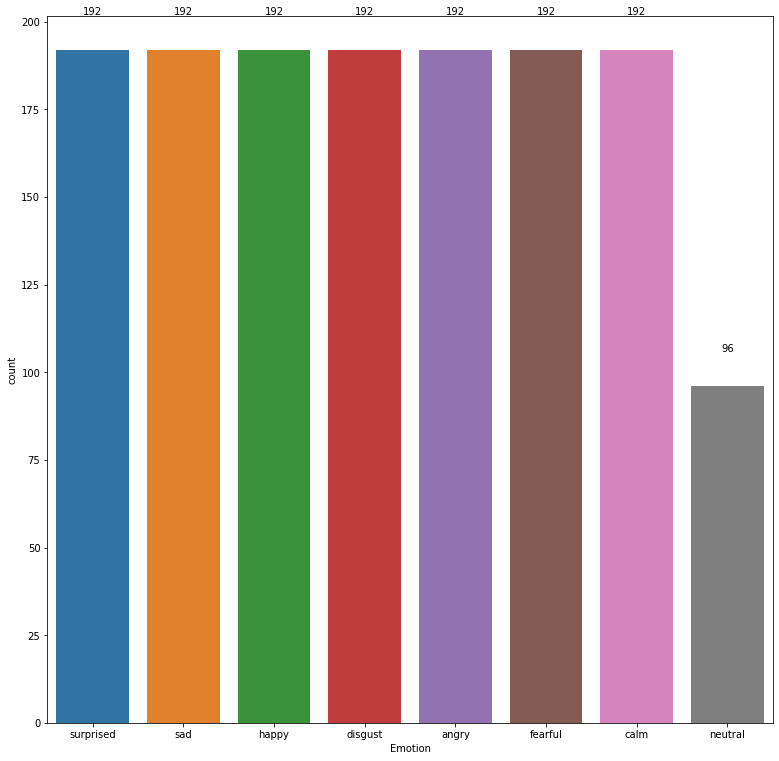

In [6]:
plot = seaborn.countplot(x='Emotion', data=result)
plot.figure.set_size_inches(13,13)

for p in plot.patches:
  height = p.get_height()
  plot.text(p.get_x() + p.get_width()/2., height + 10, '{:1.0f}'.format(height), ha="center") 

# Labeling

,Actor,Recording,Emotion,Intensity
1,Actor_01,03-01-04-02-02-02-01.wav,sad,02
2,Actor_01,03-01-03-02-02-02-01.wav,happy,02
5,Actor_01,03-01-05-01-02-02-01.wav,angry,01
8,Actor_01,03-01-03-01-01-02-01.wav,happy,01
10,Actor_01,03-01-05-01-01-01-01.wav,angry,01
...,...,...,...,...
1433,Actor_24,03-01-02-02-02-02-24.wav,calm,02
1434,Actor_24,03-01-05-01-01-01-24.wav,angry,01
1435,Actor_24,03-01-04-01-02-01-24.wav,sad,01
1437,Actor_24,03-01-03-02-01-01-24.wav,happy,02


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


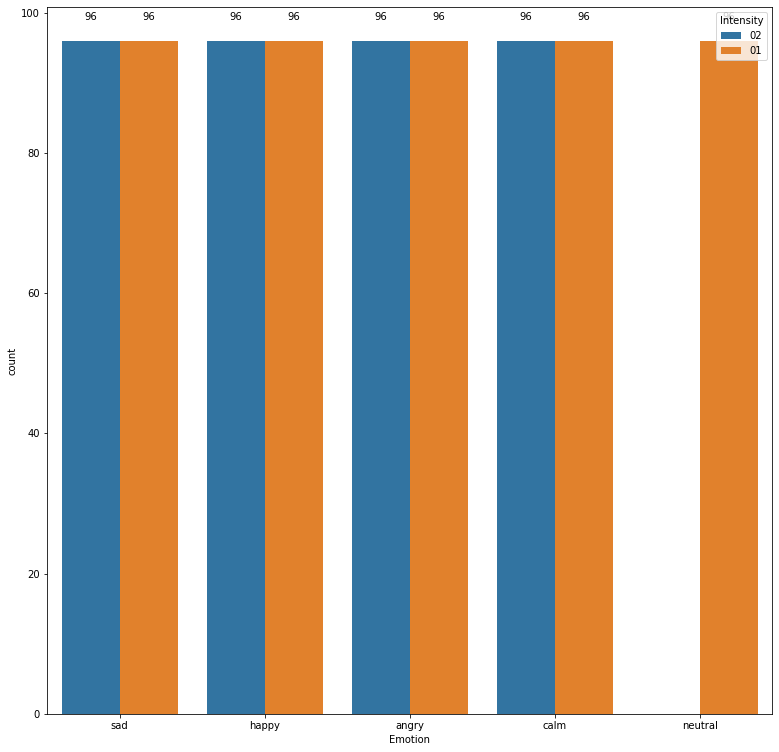

In [17]:
def getClassificationReport():
  categorical_data = result.loc[
    (
      (result["Emotion"] == 'neutral') |
      (result["Emotion"] == 'angry') |
      (result["Emotion"] == 'happy') |
      (result["Emotion"] == 'sad') |
      (result["Emotion"] == 'calm') 
    )
  ]
  
  categorical_plot = seaborn.countplot(x="Emotion", hue="Intensity", data=categorical_data)
  categorical_plot.figure.set_size_inches(13,13)

  for p in categorical_plot.patches:
    height = p.get_height()
    categorical_plot.text(p.get_x() + p.get_width()/2., height + 3, '{:1.0f}'.format(height), ha="center") 

  return categorical_data

getClassificationReport()

# Selection and Splitting

In [76]:
def checkAndCreateDirectory(filename):
  if not os.path.exists(os.path.dirname(filename)):
    try:
        os.makedirs(os.path.dirname(filename))
    except OSError as exc: # Guard against race condition
        print(exc.errno)
        if exc.errno != errno.EEXIST:
            raise

def getMfccValue(audio_path, row, dataset_type):
  audio_file, sample_rate = librosa.load(audio_path)
  # audio_file = denoise_wavelet(audio_file, method='VisuShrink', rescale_sigma=True)

  S = librosa.feature.melspectrogram(y=audio_file, sr=22000)
  # S[S < (np.average(S) * 1.0)] = np.average(S) * 0.1

  librosa.display.specshow(librosa.power_to_db(S, ref=np.max))

  filename = "image/" + dataset_type + "/" + row["Emotion"] + "/" + row["Actor"] + "_" + row["Recording"] + '.png'
  checkAndCreateDirectory(filename)

  plt.gca().set_axis_off()
  plt.savefig(filename, dpi=100, bbox_inches='tight',pad_inches=0)
  # plt.show()
  plt.clf()
  plt.close('all')

  return S

def getEncodedLabel(label):
  label_hot = [0, 0, 0, 0]
  
  if    (label == "neutral"):    label_hot = [1, 0, 0, 0, 0, 0, 0, 0]
  elif  (label == "angry"):      label_hot = [0, 1, 0, 0, 0, 0, 0, 0]
  elif  (label == "happy"):      label_hot = [0, 0, 1, 0, 0, 0, 0, 0]
  elif  (label == "sad"):        label_hot = [0, 0, 0, 1, 0, 0, 0, 0]
  elif  (label == "calm"):       label_hot = [0, 0, 0, 0, 1, 0, 0, 0]
  elif  (label == "fearful"):    label_hot = [0, 0, 0, 0, 0, 1, 0, 0]
  elif  (label == "disgust"):    label_hot = [0, 0, 0, 0, 0, 0, 1, 0]
  elif  (label == "surprised"):  label_hot = [0, 0, 0, 0, 0, 0, 0, 1]

  np.where(np.array(label_hot) == 1)[0][0]
  return np.array(label_hot)

def getAudioPath(row):
  actor = row['Actor']
  recording = row['Recording']

  audio_path = actor + '/' + recording
  return audio_path

def getVectorAudio(durationed_data, dataset_type):
  X = [] # Data
  Y = [] # Label

  durationed_length = len(durationed_data)

  # Iterate every data
  for index, row in durationed_data.iterrows():
    print("Saving " + str(durationed_length), end=" | ")

    if durationed_length % 30 == 0: print("\n")
    durationed_length -= 1

    # Get Label
    label = row["Emotion"]
    label_hot = getEncodedLabel(label)

    # Get Mfcc
    audio_path = getAudioPath(row)
    mfcc = getMfccValue(audio_path, row, dataset_type)
    
    # X.append(np.mean(mfcc.T, axis=0))
    # Y.append(label_hot)
    
    mfcc_length = mfcc.shape[1]
    mfcc_slice = 150

    for mfcc_partial in range(int(mfcc_length/mfcc_slice)):
      start = mfcc_partial * mfcc_slice
      end = (mfcc_partial + 1) * mfcc_slice

      mfcc_partial_result = np.pad(mfcc, pad_width=((0,0), (0, (mfcc_slice - (mfcc_length % mfcc_slice)))), mode='constant')
      mfcc_partial_result = mfcc_partial_result[:,start:end]

      if (mfcc_partial_result.shape[1] != mfcc_slice) | (mfcc_partial_result.shape[0] != 128):
        print("ERROR Mfcc " + str(index) + str(row))
        print("ERROR Mfcc " + index + row)
        break
      
      X.append(mfcc_partial_result)
      Y.append(label_hot)

  return np.array(X), np.array(Y)

# def testDuration():
#   audio_file, sample_rate = librosa.load('/content/gdrive/My Drive/Public/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M008.wav')
#   duration = librosa.get_duration(y=audio_file, sr=sample_rate)
#   print(duration)

#   S = librosa.feature.mfcc(y=audio_file, sr=48000)
#   print(S.shape)

def getEmotionSplitting():
  train_data    = pd.DataFrame()
  val_data      = pd.DataFrame()
  test_data     = pd.DataFrame()

  neutral_duration = result.loc[
    (result["Intensity"] == '01') &
    (result["Emotion"]  == 'neutral')
  ]

  angry_duration = result.loc[
    (result["Intensity"] == '02') &
    (result["Emotion"]  == 'angry')
  ]

  sad_duration = result.loc[
    (result["Intensity"] == '02') &
    (result["Emotion"]  == 'sad')
  ]

  happy_duration = result.loc[
    (result["Intensity"] == '02') &
    (result["Emotion"]  == 'happy')
  ]
  
  calm_duration = result.loc[
    (result["Intensity"] == '02') &
    (result["Emotion"]  == 'calm')
  ]
  
  fearful_duration = result.loc[
    (result["Intensity"] == '02') &
    (result["Emotion"]  == 'fearful')
  ]
  
  disgust_duration = result.loc[
    (result["Intensity"] == '02') &
    (result["Emotion"]  == 'disgust')
  ]
  
  surprised_duration = result.loc[
    (result["Intensity"] == '02') &
    (result["Emotion"]  == 'surprised')
  ]
    
  print("Neutral " + str(neutral_duration.shape[0]))
  print("Angry " + str(angry_duration.shape[0]))
  print("Sad " + str(sad_duration.shape[0]))
  print("Happy " + str(happy_duration.shape[0]))
  print("Calm " + str(calm_duration.shape[0]))
  print("Fear " + str(fearful_duration.shape[0]))
  print("Disgust " + str(disgust_duration.shape[0]))
  print("Surprise " + str(surprised_duration.shape[0]))
  print()

  sample_lowest = min(
    neutral_duration.shape[0], 
    angry_duration.shape[0], 
    sad_duration.shape[0], 
    happy_duration.shape[0], 
    calm_duration.shape[0], 
    fearful_duration.shape[0], 
    disgust_duration.shape[0], 
    surprised_duration.shape[0] 
  )

  neutral_duration      = neutral_duration.sample(sample_lowest)
  angry_duration        = angry_duration.sample(sample_lowest)
  sad_duration          = sad_duration.sample(sample_lowest)
  happy_duration        = happy_duration.sample(sample_lowest)
  calm_duration         = calm_duration.sample(sample_lowest)
  fearful_duration      = fearful_duration.sample(sample_lowest)
  disgust_duration      = disgust_duration.sample(sample_lowest)
  surprised_duration    = surprised_duration.sample(sample_lowest)

  # Splitting # 0,6 : 0,8 : 1,0 (60%, 20%, 20%)
  data_training_percent   = int(0.6 * sample_lowest)
  data_validation_percent = int(0.8 * sample_lowest)

  train_data = train_data.append(neutral_duration   [:data_training_percent])
  train_data = train_data.append(angry_duration     [:data_training_percent])
  train_data = train_data.append(sad_duration       [:data_training_percent])
  train_data = train_data.append(happy_duration     [:data_training_percent])
  train_data = train_data.append(calm_duration      [:data_training_percent])
  train_data = train_data.append(fearful_duration   [:data_training_percent])
  train_data = train_data.append(disgust_duration   [:data_training_percent])
  train_data = train_data.append(surprised_duration [:data_training_percent])

  val_data = val_data.append(neutral_duration     [data_training_percent:data_validation_percent])
  val_data = val_data.append(angry_duration       [data_training_percent:data_validation_percent])
  val_data = val_data.append(sad_duration         [data_training_percent:data_validation_percent])
  val_data = val_data.append(happy_duration       [data_training_percent:data_validation_percent])
  val_data = val_data.append(calm_duration        [data_training_percent:data_validation_percent])
  val_data = val_data.append(fearful_duration     [data_training_percent:data_validation_percent])
  val_data = val_data.append(disgust_duration     [data_training_percent:data_validation_percent])
  val_data = val_data.append(surprised_duration   [data_training_percent:data_validation_percent])

  test_data = test_data.append(neutral_duration     [data_validation_percent:sample_lowest])
  test_data = test_data.append(angry_duration       [data_validation_percent:sample_lowest])
  test_data = test_data.append(sad_duration         [data_validation_percent:sample_lowest])
  test_data = test_data.append(happy_duration       [data_validation_percent:sample_lowest])
  test_data = test_data.append(calm_duration        [data_validation_percent:sample_lowest])
  test_data = test_data.append(fearful_duration     [data_validation_percent:sample_lowest])
  test_data = test_data.append(disgust_duration     [data_validation_percent:sample_lowest])
  test_data = test_data.append(surprised_duration   [data_validation_percent:sample_lowest])

  return train_data.sample(frac=1), val_data.sample(frac=1), test_data.sample(frac=1)

train_data, val_data, test_data = getEmotionSplitting()
!rm -rf image

# In vector and save image
x_train, y_train  = getVectorAudio(train_data, "train")
x_val, y_val      = getVectorAudio(val_data, "val")
x_test, y_test    = getVectorAudio(test_data, "test")

Neutral 96
Angry 96
Sad 96
Happy 96
Calm 96
Fear 96
Disgust 96
Surprise 96

Saving 456 | Saving 455 | Saving 454 | Saving 453 | Saving 452 | Saving 451 | Saving 450 | 

Saving 449 | Saving 448 | Saving 447 | Saving 446 | Saving 445 | Saving 444 | Saving 443 | Saving 442 | Saving 441 | Saving 440 | Saving 439 | Saving 438 | Saving 437 | Saving 436 | Saving 435 | Saving 434 | Saving 433 | Saving 432 | Saving 431 | Saving 430 | Saving 429 | Saving 428 | Saving 427 | Saving 426 | Saving 425 | Saving 424 | Saving 423 | Saving 422 | Saving 421 | Saving 420 | 

Saving 419 | Saving 418 | Saving 417 | Saving 416 | Saving 415 | Saving 414 | Saving 413 | Saving 412 | Saving 411 | Saving 410 | Saving 409 | Saving 408 | Saving 407 | Saving 406 | Saving 405 | Saving 404 | Saving 403 | Saving 402 | Saving 401 | Saving 400 | Saving 399 | Saving 398 | Saving 397 | Saving 396 | Saving 395 | Saving 394 | Saving 393 | Saving 392 | Saving 391 | Saving 390 | 

Saving 389 | Saving 388 | Saving 387 | Saving 3

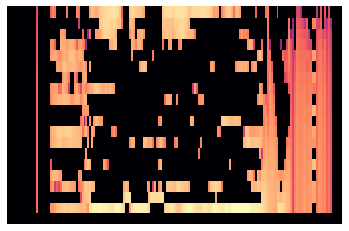

In [43]:
audio_file, sample_rate = librosa.load('Actor_01/03-01-03-02-02-01-01.wav')

S = librosa.feature.mfcc(y=audio_file, sr=48000)
librosa.display.specshow(librosa.power_to_db(S, ref=0))

plt.gca().set_axis_off()
plt.savefig("/content/test.png", dpi=1000, bbox_inches='tight',pad_inches=0)
plt.show()
plt.clf()
plt.close('all')

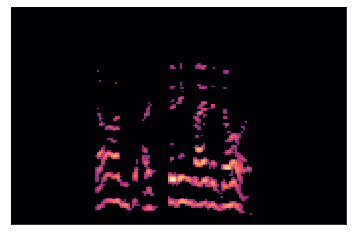

In [44]:
S = librosa.feature.melspectrogram(y=audio_file, sr=48000)
S[S < (np.average(S) * 1.)] = 0.001

librosa.display.specshow(librosa.power_to_db(S, ref=np.max))

In [77]:
def loadGenerator():
  # 352, 235
  train_image_generator = ImageDataGenerator()
  train_data = train_image_generator.flow_from_directory(
      directory="image/train/",
      class_mode="categorical",
      batch_size=4,
      shuffle=True,
      target_size=(128, 128)
  )
    
  validation_image_generator = ImageDataGenerator()
  validation_data = validation_image_generator.flow_from_directory(
      directory="image/val/",
      class_mode="categorical",
      batch_size=1,
      shuffle=True,
      target_size=(128, 128)
  )

  test_image_generator = ImageDataGenerator()
  test_data = test_image_generator.flow_from_directory(
      directory="image/test/",
      batch_size=1,
      class_mode="categorical",
      shuffle=True,
      target_size=(128, 128)
  )

  return train_data, validation_data, test_data

# def scaleVector():
#   scaler = MinMaxScaler()

#   x_train_scaled = []
#   x_val_scaled = []

#   for x in x_train:
#     scaler.partial_fit(x)

#   for x in x_val:
#     scaler.partial_fit(x)

#   for x in x_train:
#     x_result = scaler.transform(x)
#     x_train_scaled.append(x_result)

#   for x in x_val:
#     x_result = scaler.transform(x)
#     x_val_scaled.append(x_result)

#   return np.array(x_train_scaled), np.array(x_val_scaled)

# In generator
train_generator, validation_generator, test_generator = loadGenerator()

# In vector
# x_train_scaled, x_val_scaled = scaleVector()

print(x_train.shape)
print(x_val.shape)

Found 456 images belonging to 8 classes.
Found 152 images belonging to 8 classes.
Found 160 images belonging to 8 classes.
(383, 128, 150)
(116, 128, 150)


Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 64, 64, 16)        2368      
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 32, 32, 32)        12832     
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 8, 8, 64)          18496     
_________________________________________________________________
conv2d_124 (Conv2D)          (None, 4, 4, 64)          36928     
_________________________________________________________________
conv2d_125 (Conv2D)          (None, 2, 2, 128)         738

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


114/114 [==============================] - 4s 25ms/step - loss: 2.3751 - accuracy: 0.1870 - val_loss: 5.8778 - val_accuracy: 0.1711

Epoch 00001: val_accuracy improved from -inf to 0.17105, saving model to /content/model/weight_model_01_2.14_0.25_5.88_0.17.hdf5
Epoch 2/100
114/114 [==============================] - 3s 23ms/step - loss: 1.7978 - accuracy: 0.4109 - val_loss: 6.2776 - val_accuracy: 0.1447

Epoch 00002: val_accuracy did not improve from 0.17105
Epoch 3/100
114/114 [==============================] - 3s 23ms/step - loss: 1.8856 - accuracy: 0.3379 - val_loss: 3.2472 - val_accuracy: 0.2566

Epoch 00003: val_accuracy improved from 0.17105 to 0.25658, saving model to /content/model/weight_model_03_1.83_0.36_3.25_0.26.hdf5
Epoch 4/100
114/114 [==============================] - 3s 23ms/step - loss: 1.8088 - accuracy: 0.4078 - val_loss: 6.6916 - val_accuracy: 0.2434

Epoch 00004: val_accuracy did not improve from 0.25658
Epoch 5/100
114/114 [==============================] - 3s 23m

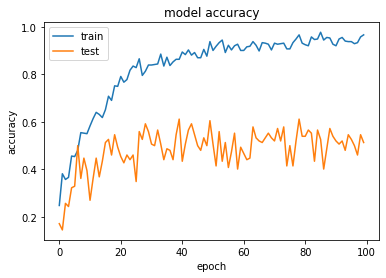

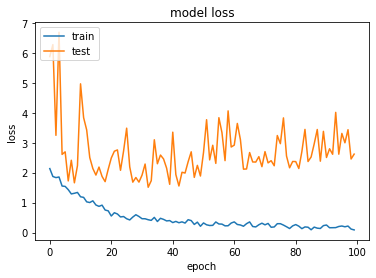

In [92]:
def plot_result(model, history):
  # list all data in history
  print(history.history.keys())

  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss') 
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

def save_model(model, filename):
  checkAndCreateDirectory("/content/model/test.txt")
  model.summary()

  plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

  with open("/content/model/" + filename + ".json", "w") as json_file:
    model_json = model.to_json()
    json_file.write(model_json)

def buildModel():
  model_input = Input(shape=(128, 128, 3))
  # model_input = Input(shape=(160, 150, 1))

  model = Conv2D(16, kernel_size=7, strides=2, padding='same', trainable=True)(model_input)
  model = Conv2D(32, kernel_size=5, strides=2, padding='same', trainable=True)(model)
  model = Conv2D(32, kernel_size=3, strides=2, padding='same', trainable=True)(model)
  model = Conv2D(64, kernel_size=3, strides=2, padding='same', trainable=True)(model)
  model = Conv2D(64, kernel_size=3, strides=2, padding='same', trainable=True)(model)
  model = Conv2D(128, kernel_size=3, strides=2, padding='same', trainable=True)(model)
  model = Conv2D(128, kernel_size=3, strides=2, padding='same', trainable=True)(model)

  model = Flatten()(model)

  model = Dense(512)(model)
  model = BatchNormalization()(model)
  model = Activation('relu')(model)
  model = Dropout(0.25)(model)

  model = Dense(8, activation='softmax')(model)
  
  # Model compile
  model = Model(inputs=[model_input], outputs=[model])
  model.compile(optimizer="adam", loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["accuracy"])
  
  # Visualize & Save Model
  save_model(model, "struct_model")

  # Checkpoint
  basepath = '/content/model/weight_model'
  best_checkpoint = ModelCheckpoint(basepath +'_{epoch:02d}_{loss:.2f}_{accuracy:.2f}_{val_loss:.2f}_{val_accuracy:.2f}.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max', period=1)
  callback_list = [best_checkpoint]

  # history = model.fit(
  #   x_train, 
  #   y_train, 
  #   validation_data=(x_val, y_val),
  #   batch_size=8, 
  #   epochs=100,
  #   callbacks=callback_list
  # )

  history = model.fit_generator(
    generator=train_generator,
    validation_data=validation_generator,
    epochs=100,
    callbacks=callback_list
  )

  return model, history

model = None
history = None

# !sudo chmod 777 /mnt
!rm -rf model
# !rm -rf /mnt/model
# !rm -rf ../.local/share/Trash/files

# device = cuda.get_current_device()
# device.reset()

model, history = buildModel()
plot_result(model, history)

In [93]:
def load_model(struct, weight):
  json_file = open("/content/model/" + struct + ".json", "r")
  loaded_model_json = json_file.read()
  json_file.close()

  loaded_model = model_from_json(loaded_model_json)
  loaded_model.load_weights("/content/model/" + weight + ".hdf5")
  loaded_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

  return loaded_model

lastCheckpoint = sorted(Path("/content/model").iterdir(), key=os.path.getmtime)[-1].stem
print("Model is " + lastCheckpoint)

loaded_model = load_model("struct_model", lastCheckpoint)

Model is weight_model_40_0.40_0.86_1.61_0.61


# Testing

In [94]:
# train_loss, train_accuracy = loaded_model.evaluate(x_train, y_train)
# val_loss, val_accuracy = loaded_model.evaluate(x_val, y_val)
# test_loss, test_accuracy = loaded_model.evaluate(x_test, y_test)

# print(
#     ""
#     "\n"
#     "Train Loss: " + str(train_loss) + "\n"
#     "Train Accuracy: " + str(train_accuracy * 100) + "%\n"
#     "\n"
#     "Validation Loss: " + str(val_loss) + "\n"
#     "Validation Accuracy: " + str(val_accuracy * 100) + "%\n"
#     "\n"
#     "Test Loss: " + str(test_loss) + "\n"
#     "Test Accuracy: " + str(test_accuracy * 100) + "%"
#     "")

In [95]:
# from google.colab import files

# best_model_file = "/content/model/" + lastCheckpoint + ".hdf5"
# files.download(best_model_file)

In [96]:
loss, accuracy = loaded_model.evaluate_generator(generator=train_generator)
print(
    ""
    "Prediction Loss: %2d\n"
    "Prediction Accuracy: %2d%%"
    ""
    % (loss, accuracy * 100))

loss, accuracy = loaded_model.evaluate_generator(generator=validation_generator)
print(
    ""
    "Prediction Loss: %2d\n"
    "Prediction Accuracy: %2d%%"
    ""
    % (loss, accuracy * 100))

loss, accuracy = loaded_model.evaluate_generator(generator=test_generator)
print(
    ""
    "Prediction Loss: %2d\n"
    "Prediction Accuracy: %2d%%"
    ""
    % (loss, accuracy * 100))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Prediction Loss:  0
Prediction Accuracy: 98%
Prediction Loss:  1
Prediction Accuracy: 61%
Prediction Loss:  1
Prediction Accuracy: 63%


# Analysis

In [ ]:
target_names = ['neu', 'ang', 'hap', "sad"]

Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)

y_decoded = []
for pred in y_test:
  decoded = np.where(pred == 1)[0][0]
  y_decoded.append(decoded)

print('Confusion Matrix')
print(target_names)
print(confusion_matrix(y_decoded, y_pred))
print(x_test.shape)

print('\n\nClassification Report')
print(classification_report(y_decoded, y_pred, target_names=target_names))

Confusion Matrix
['neu', 'ang', 'hap', 'sad']
[[ 3  2  7  3]
 [ 2  6  6  3]
 [ 7  3  5  3]
 [ 3  0  4 10]]
(67, 128, 50)


Classification Report
              precision    recall  f1-score   support

         neu       0.20      0.20      0.20        15
         ang       0.55      0.35      0.43        17
         hap       0.23      0.28      0.25        18
         sad       0.53      0.59      0.56        17

    accuracy                           0.36        67
   macro avg       0.37      0.35      0.36        67
weighted avg       0.38      0.36      0.36        67



In [ ]:
target_names = ['neu', 'ang', 'hap', "sad"]

Y_pred = model.predict_generator(test_data)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_data.classes, y_pred))

print('\n\nClassification Report')
print(classification_report(test_data.classes, y_pred, target_names=target_names))